In [76]:
# Import packages

import time
import re

import pandas as pd
import numpy as np
#import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

### Import Data

In [3]:
%%time

# Read in 311 data
df_311 = pd.read_csv('Data/311_Service_Requests_20240430.csv',
                     index_col = 'Unique Key',
                     usecols = ['Agency','Borough','Complaint Type',
                              'Created Date','Incident Zip',#'Latitude','Longitude',
                              'Unique Key'],
                     dtype = {'Agency':'category','Borough':'category','Complaint Type':str,
                              'Created Date':str,'Incident Zip':str,#'Latitude':float,'Longitude':float,
                              'Unique Key':'int64'})

# Rename columns
df_311.rename({'Complaint Type': 'Type', 'Created Date': 'Date', 'Incident Zip': 'Zip'}, axis=1, inplace=True)

CPU times: total: 3min 22s
Wall time: 3min 27s


In [4]:
# Read in NYC weather data, and format

df_weather = pd.read_csv('Data/NYC_weather_data.csv')
df_weather.drop_duplicates(inplace=True)
df_weather.drop('Unnamed: 0', axis=1, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date']).values.astype('datetime64[D]')
df_weather.set_index('date',inplace=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10466 entries, 2010-01-01 to 2024-04-30
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   weather_code         float64
 1   temperature_2m_max   float64
 2   temperature_2m_min   float64
 3   temperature_2m_mean  float64
 4   daylight_duration    float64
 5   rain_sum             float64
 6   snowfall_sum         float64
 7   wind_speed_10m_max   float64
dtypes: float64(8)
memory usage: 735.9 KB


In [5]:
# Read in NYC zip codes

df_zip = pd.read_csv('Data/uszips/uszips.csv',
                     index_col = 'zip',
                     dtype = {'borough': str, 'zip': str} )

In [6]:
# Load shapefile of zip codes
#filtered_shapefile_path = 'Data/USA_ZIP_Code_Boundaries/filtered_zip_code_shapefile.shp'
#filtered_zip_codes_gdf = gpd.read_file(filtered_shapefile_path)

### Drop unusable rows

In [7]:
print(f'Initial items: {len(df_311):,.0f}')

Initial items: 36,217,243


In [8]:
# Drop rows with no useable location data
no_loc = df_311['Zip'].isna() #& df_311['Latitude'].isna()
df_311 = df_311[~no_loc]
print(f'Rows with locations: {len(df_311):,.0f}')

Rows with locations: 34,682,301


In [9]:
%%time
# Convert date columns to datetime, dropping time component and dropping dates after March 31, 2024
date_format = '%m/%d/%Y %I:%M:%S %p'
df_311['Date'] = pd.to_datetime(df_311['Date'], format=date_format).values.astype('datetime64[D]')
df_311 = df_311[df_311['Date'] < pd.Timestamp('2024-04-01')]
print(f'Rows in the date range: {len(df_311):,.0f}')

Rows in the date range: 34,435,921
CPU times: total: 2min 30s
Wall time: 2min 31s


In [10]:
# Convert NaN values in 'Incident Zip' to 'empty', to simplify further processing
df_311['Zip'] = df_311['Zip'].fillna('empty')
df_311.isna().sum()

# Clean up ZIP codes by removing '-####' if present
df_311['Zip'] = df_311['Zip'].str.replace(r'-\d{4}$', '', regex=True)

# Drop all rows with zip codes not in NYC
df_311 = df_311[df_311['Zip'].isin(df_zip.index)]
print(f'Rows in NYC: {len(df_311):,.0f}')

Rows in NYC: 34,388,549


In [11]:
# Fill in latitude and longitude when a zip code is available

# Latitude and longitude from US Zip Code file
#zip_to_lat = df_zip['lat'].to_dict()
#zip_to_lng = df_zip['lng'].to_dict()

# Fill in missing latitude and longitude using the mapping, but only if values don't already exist
#df_311.loc[df_311['Latitude'].isna(), 'Latitude'] = df_311['Zip'].map(zip_to_lat)
#df_311.loc[df_311['Longitude'].isna(), 'Longitude'] = df_311['Zip'].map(zip_to_lng)

#### Consolidate Agencies and Types

In [12]:
# Consolidate agencies, replacing minor agencies with 'Other'
agency_dict = {
    'NYPD': 'Police',
    'HPD': 'Housing',
    'DSNY': 'Sanitation',
    'DOT': 'Transportation',
    'DEP': 'Environment',
    'DOB': 'Buildings',
    'DPR': 'Parks',
    'DOMHM': 'Health',
    'DOF': 'Finance',
    'TLC': 'Taxi',
    'DHS': 'Homeless',
    'DCA': 'Consumer',
    'DEPARTMENT OF CONSUMER AND WORKER PROTECTION': 'Consumer',
    'EDC': 'Development',
    'HRA': 'Human Resources',
    'DFTA': 'Aging',
    'OSE': 'ST Rentals',
}

df_311['Agency'] = df_311['Agency'].map(agency_dict).fillna('Other')

In [13]:
# Convert all line items to lowercase
df_311['Type'] = df_311['Type'].str.lower()

In [14]:
# Convert complaint types to fewer categories
complaint_dict = {
    'noise - residential': 'Noise',
    'illegal parking': 'Vehicle',
    'heat/hot water': 'Resident Utility',
    'blocked driveway': 'Vehicle',
    'street condition': 'Street Condition',
    'noise - street/sidewalk': 'Noise',
    'street light condition': 'Traffic Device',
    'request large bulky item collection': 'Item Pickup',
    'plumbing': 'Resident Utility',
    'heating': 'Resident Utility',
    'water system': 'Resident Utility',
    'unsanitary condition': 'Sanitation',
    'noise': 'Noise',
    'general construction/plumbing': 'Resident Utility',
    'traffic signal condition': 'Traffic Device',
    'noise - commercial': 'Noise',
    'paint/plaster': 'Buildings',
    'noise - vehicle': 'Noise',
    'general construction': 'Construction',
    'sewer': 'Sewer',
    'damaged tree': 'Tree',
    'rodent': 'Sanitation',
    'dirty conditions': 'Sanitation',
    'electric': 'Resident Utility',
    'derelict vehicles': 'Vehicle',
    'sanitation condition': 'Sanitation',
    'door/window': 'Buildings',
    'paint - plaster': 'Buildings',
    'sidewalk condition': 'Street Condition',
    'water leak': 'Resident Utility',
    'building/use': 'Buildings',
    'missed collection (all materials)': 'Sanitation',
    'literature request': 'Other',
    'consumer complaint': 'Consumer',
    'general': 'Other',
    'homeless person assistance': 'Social Services',
    'nonconst': 'Other',
    'abandoned vehicle': 'Vehicle',
    'new tree request': 'Tree',
    'flooring/stairs': 'Buildings',
    'graffiti': 'Quality of Life',
    'overgrown tree/branches': 'Tree',
    'non-emergency police matter': 'Police',
    'derelict vehicle': 'Vehicle',
    'maintenance or facility': 'Other',
    'taxi complaint': 'Taxi',
    'appliance': 'Buildings',
    'elevator': 'Buildings',
    'broken muni meter': 'Parking',
    'missed collection': 'Sanitation',
    'noise - helicopter': 'Noise',
    'root/sewer/sidewalk condition': 'Street Condition',
    'food establishment': 'Vendors',
    'for hire vehicle complaint': 'Taxi',
    'dirty condition': 'Sanitation',
    'air quality': 'Environmental',
    'benefit card replacement': 'Social Services',
    'encampment': 'Social Services',
    'dof property - reduction issue': 'Finance',
    'lead': 'Public Health',
    'safety': 'Other',
    'street sign - damaged': 'Traffic Device',
    'illegal fireworks': 'Quality of Life',
    'snow': 'Snow',
    'electronics waste appointment': 'Item Pickup',
    'scrie': 'Housing',
    'dead/dying tree': 'Tree',
    'illegal dumping': 'Sanitation',
    'broken parking meter': 'Parking',
    'other enforcement': 'Police',
    'dof parking - payment issue': 'Finance',
    'indoor air quality': 'Buildings',
    'noise - park': 'Noise',
    'curb condition': 'Street Condition',
    'street sign - missing': 'Traffic Device',
    'noncompliance with phased reopening': 'Public Health',
    'dof property - owner issue': 'Finance',
    'traffic': 'Traffic Device',
    'dof property - request copy': 'Finance',
    'highway condition': 'Street Condition',
    'dead tree': 'Tree',
    'emergency response team (ert)': 'Buildings',
    'special projects inspection team (spit)': 'Construction',
    'water conservation': 'Parks and Rec',
    'dof property - payment issue': 'Finance',
    'hpd literature request': 'Housing',
    'animal abuse': 'Animal',
    'housing - low income senior': 'Housing',
    'drug activity': 'Police',
    'vending': 'Quality of Life',
    'electrical': 'Resident Utility',
    'illegal tree damage': 'Tree',
    'dhs advantage - tenant': 'Housing',
    'food poisoning': 'Public Health',
    'street sign - dangling': 'Traffic Device',
    'violation of park rules': 'Parks and Rec',
    'homeless encampment': 'Social Services',
    'smoking': 'Public Health',
    'animal-abuse': 'Animal',
    'animal in a park': 'Animal',
    'hazardous materials': 'Environmental',
    'obstruction': 'Vehicle',
    'construction': 'Construction',
    'lost property': 'Other',
    'litter basket / request': 'Sanitation',
    'boilers': 'Resident Utility',
    'construction safety enforcement': 'Construction',
    'dhs advantage -landlord/broker': 'Housing',
    'unsanitary animal pvt property': 'Animal',
    'drinking': 'Social Services',
    'residential disposal complaint': 'Sanitation',
    'standing water': 'Environmental',
    'electronics waste': 'Item Pickup',
    'panhandling': 'Social Services',
    'dca / doh new license application request': 'Vendors',
    'asbestos': 'Buildings',
    'dead animal': 'Animal',
    'dof property - update account': 'Finance',
    'outdoor dining': 'Vendors',
    'best/site safety': 'Construction',
    'street sweeping complaint': 'Street Condition',
    'water quality': 'Resident Utility',
    'vendor enforcement': 'Vendors',
    'real time enforcement': 'Buildings',
    'housing options': 'Housing',
    'bus stop shelter complaint': 'Social Services',
    'industrial waste': 'Environmental',
    'bike/roller/skate chronic': 'Quality of Life',
    'mobile food vendor': 'Vendors',
    'overflowing litter baskets': 'Sanitation',
    'derelict bicycle': 'Vehicle',
    'noise survey': 'Noise',
    'non-residential heat': 'Buildings',
    'miscellaneous categories': 'Other',
    'homeless street condition': 'Social Services',
    'noise - house of worship': 'Noise',
    'taxi report': 'Taxi',
    'traffic/illegal parking': 'Vehicle',
    'unleashed dog': 'Animal',
    'indoor sewage': 'Resident Utility',
    'outside building': 'Other',
    'snow or ice': 'Snow',
    'dof parking - request status': 'Finance',
    'unsanitary pigeon condition': 'Animal',
    'sweeping/missed': 'Street Condition',
    'dof parking - request copy': 'Finance',
    'recycling enforcement': 'Sanitation',
    'dpr internal': 'Parks and Rec',
    'urinating in public': 'Social Services',
    'litter basket request': 'Sanitation',
    'day care': 'Social Services',
    'illegal posting': 'Quality of Life',
    'borough office': 'Other',
    'sanitation worker or vehicle complaint': 'Sanitation',
    'vaccine mandate non-compliance': 'Public Health',
    'covid-19 non-essential construction': 'Construction',
    'building marshals office': 'Buildings',
    'commercial disposal complaint': 'Sanitation',
    'dof parking - tax exemption': 'Finance',
    'bridge condition': 'Street Condition',
    'sustainability enforcement': 'Sanitation',
    'taxi compliment': 'Taxi',
    'elder abuse': 'Social Services',
    'sweeping/missed-inadequate': 'Street Condition',
    'disorderly youth': 'Social Services',
    'abandoned bike': 'Vehicle',
    'mold': 'Buildings',
    'dumpster complaint': 'Sanitation',
    'illegal animal kept as pet': 'Animal',
    'mosquitoes': 'Environmental',
    'for hire vehicle report': 'Taxi',
    'drie': 'Housing',
    'found property': 'Other',
    'home delivered meal - missed delivery': 'Social Services',
    'litter basket complaint': 'Sanitation',
    'construction lead dust': 'Environmental',
    'mass gathering complaint': 'Quality of Life',
    'cranes and derricks': 'Construction',
    'dof property - rpie issue': 'Finance',
    'posting advertisement': 'Quality of Life',
    'home repair': 'Buildings',
    'harboring bees/wasps': 'Animal',
    'scaffold safety': 'Construction',
    'adopt-a-basket': 'Sanitation',
    'senior center complaint': 'Social Services',
    'plant': 'Other',
    'window guard': 'Buildings',
    'sewer maintenance': 'Sewer',
    'snow removal': 'Snow',
    'sweeping/inadequate': 'Street Condition',
    "alzheimer's care": 'Social Services',
    'beach/pool/sauna complaint': 'Parks and Rec',
    'city vehicle placard complaint': 'Other',
    'drinking water': 'Resident Utility',
    'collection truck noise': 'Sanitation',
    'question': 'Other',
    'facades': 'Buildings',
    'private or charter school reopening': 'Public Health',
    'dof property - property value': 'Finance',
    'dof parking - dmv clearance': 'Finance',
    'request xmas tree collection': 'Item Pickup',
    'poison ivy': 'Environmental',
    'oem disabled vehicle': 'Vehicle',
    'uprooted stump': 'Tree',
    'wood pile remaining': 'Construction',
    'face covering violation': 'Public Health',
    'tattooing': 'Other',
    'heap assistance': 'Resident Utility',
    'highway sign - damaged': 'Traffic Device',
    'quality of life': 'Quality of Life',
    'utility program': 'Resident Utility',
    'executive inspections': 'Buildings',
    'forms': 'Other',
    'dhs advantage - third party': 'Public Health',
    'unsanitary animal facility': 'Vendors',
    'green taxi complaint': 'Taxi',
    'dof property - city rebate': 'Finance',
    'forensic engineering': 'Buildings',
    'weatherization': 'Buildings',
    'pet shop': 'Vendors',
    'animal facility - no permit': 'Vendors',
    'special natural area district (snad)': 'Parks and Rec',
    'municipal parking facility': 'Parking',
    'home delivered meal complaint': 'Social Services',
    'illegal animal sold': 'Animal',
    'seasonal collection': 'Item Pickup',
    'dep street condition': 'Street Condition',
    'stalled sites': 'Other',
    'advocate-personal exemptions': 'Finance',
    'highway sign - missing': 'Traffic Device',
    'ahv inspection unit': 'Vendors',
    'e-scooter': 'Quality of Life',
    'public toilet': 'Parks and Rec',
    'eviction': 'Housing',
    'fatf': 'Finance',
    'dof parking - address update': 'Parking',
    'advocate-prop refunds/credits': 'Finance',
    'water maintenance': 'Resident Utility',
    'highway sign - dangling': 'Traffic Device',
    'parking card': 'Parking',
    'taxpayer advocate inquiry': 'Finance',
    'summer camp': 'Parks and Rec',
    'special operations': 'Quality of Life',
    'incorrect data': 'Other',
    'bereavement support group': 'Social Services',
    'advocate - other': 'Social Services',
    'lifeguard': 'Parks and Rec',
    'squeegee': 'Quality of Life',
    'x-ray machine/equipment': 'Other',
    'home care provider complaint': 'Social Services',
    'case management agency complaint': 'Social Services',
    'atf': 'Police',
    'private school vaccine mandate non-compliance': 'Public Health',
    'overflowing recycling baskets': 'Sanitation',
    'comments': 'Other',
    'cooling tower': 'Buildings',
    'recycling basket complaint': 'Sanitation',
    'calorie labeling': 'Vendors',
    'legal services provider complaint': 'Social Services',
    'health': 'Public Health',
    'radioactive material': 'Environmental',
    'dhs income savings requirement': 'Housing',
    'institution disposal complaint': 'Sanitation',
    'water drainage': 'Environmental',
    'green taxi report': 'Taxi',
    'peeling paint': 'Buildings',
    'tunnel condition': 'Street Condition',
    'building drinking water tank': 'Buildings',
}    

In [15]:
df_311['Type'] = df_311['Type'].map(complaint_dict).fillna('Other')

#### Quick Visualizations

In [16]:
# Clean Borough values for charting
df_311['Borough'] = df_311['Borough'].str.title()

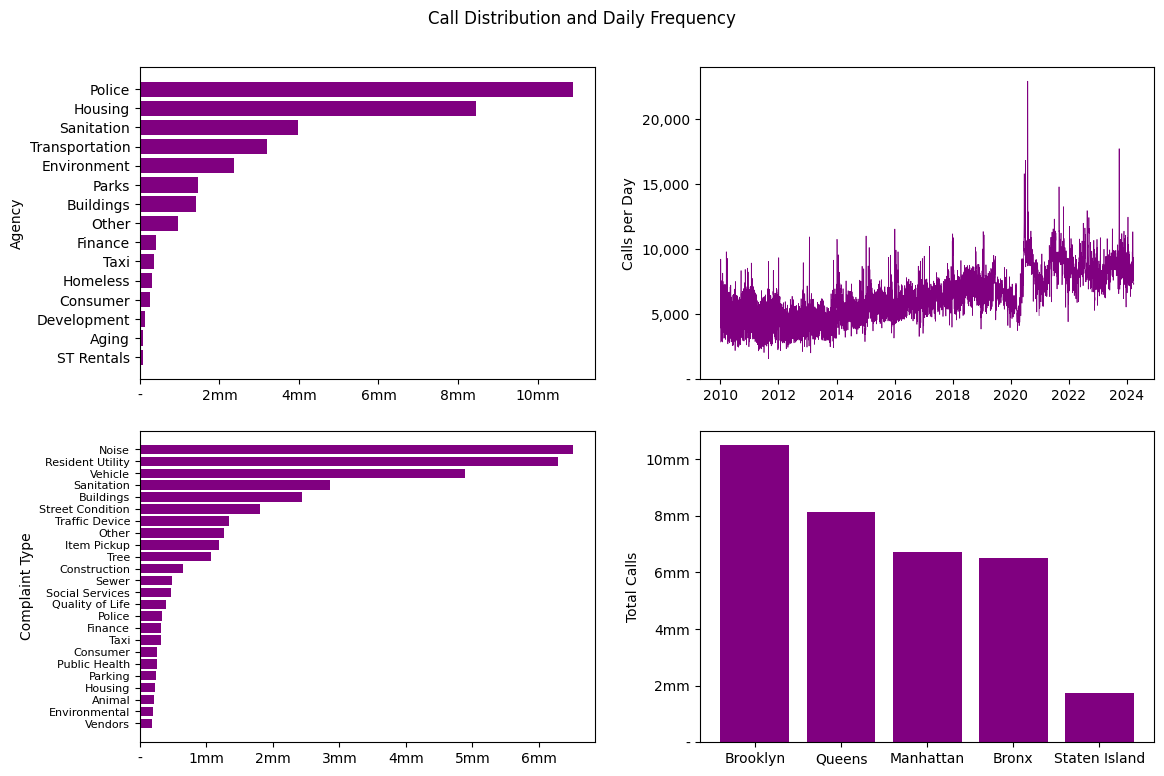

In [17]:
# Visualize call data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Call Distribution and Daily Frequency')
ax1.barh(y = df_311['Agency'].value_counts().sort_values(ascending=True).index[1:], width = df_311['Agency'].value_counts().sort_values(ascending=True)[1:], color='purple')
ax1.set_xticks([0,2000000,4000000,6000000,8000000,10000000])
ax1.set_xticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax1.set_ylabel('Agency')
ax2.plot(df_311['Date'].value_counts().sort_index(), linewidth=0.5, color='purple')
ax2.set_yticks([0,5000,10000,15000,20000])
ax2.set_yticklabels(['-','5,000','10,000','15,000','20,000'])
ax2.set_ylabel('Calls per Day')
ax3.barh(y= df_311['Type'].value_counts().sort_values(ascending=True).index[2:], width = df_311['Type'].value_counts().sort_values(ascending=True)[2:], color='purple')
ax3.tick_params(axis='y', labelsize=8)
ax3.set_xticks([0,1000000,2000000,3000000,4000000,5000000,6000000])
ax3.set_xticklabels(['-','1mm','2mm','3mm','4mm','5mm','6mm'])
ax3.set_ylabel('Complaint Type')
ax4.bar(x=df_311['Borough'].value_counts().sort_values(ascending=False)[:-1].index, height=df_311['Borough'].value_counts().sort_values(ascending=False)[:-1], color='purple')
ax4.set_yticks([0,2000000,4000000,6000000,8000000,10000000])
ax4.set_yticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax4.set_ylabel('Total Calls')
plt.tight_layout(pad=2.0)
plt.show()

### Weather

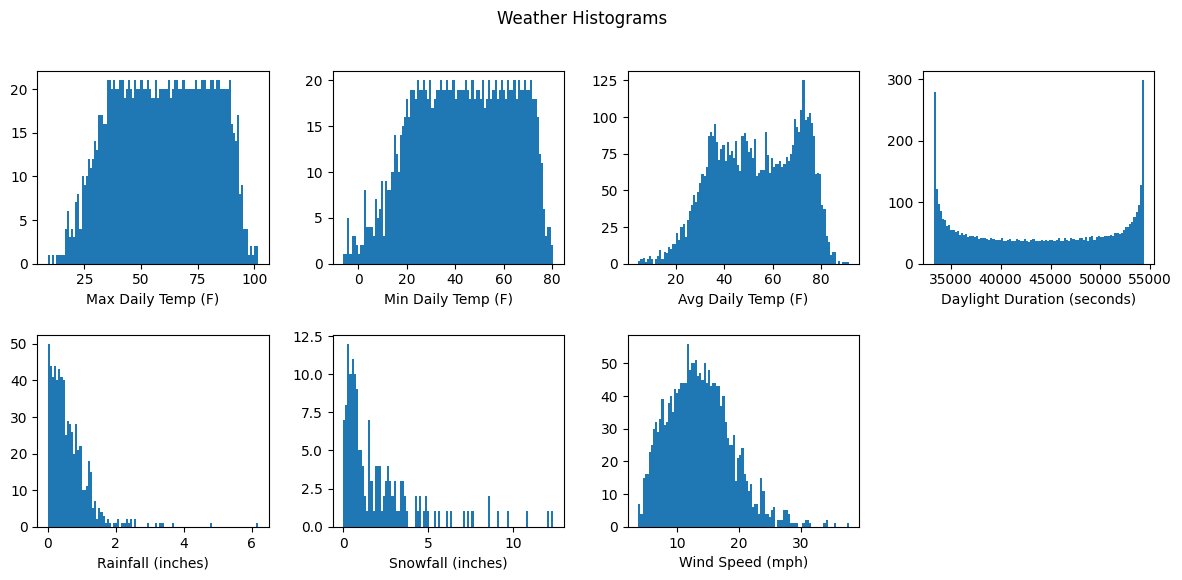

In [18]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')
ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
- Rainfall and snowfall: Log Transform, but remember to add a small constant to avoid taking log of zero, then consider minmax scale [0,1] the result
- Wind speed: Log Transform, but probably no need to add small constant
- Temperatures - Seasonal decompose first, then minmax scale, then seasonal recompose
- Daylight Duration - Minmax scaling

### Baseline Model

In [19]:
df_311_agg = df_311.drop(columns=['Borough','Agency','Type','Zip'], axis=1)

In [22]:
df_311_pivot = df_311_agg.groupby('Date').size().reset_index(name='Count')
df_311_pivot.set_index('Date', inplace=True)

In [26]:
df_311_pivot['Pred_Baseline'] = df_311_pivot['Count'].shift(1)

In [28]:
df_311_pivot.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5204 entries, 2010-01-01 to 2024-03-31
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Count          5204 non-null   int64  
 1   Pred_Baseline  5203 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 122.0 KB


In [29]:
train_df = df_311_pivot[:4163]  # About 80%
test_df = df_311_pivot[4163:]   # About 20%

In [45]:
print('Baseline errors')
print('-------------------------')
print(f'MAE: {mean_absolute_error(test_df['Count'], test_df['Pred_Baseline'])}')
print(f'MAPE: {mean_absolute_percentage_error(test_df['Count'], test_df['Pred_Baseline']):.4f}')
print(f'MSE: {mean_squared_error(test_df['Count'], test_df['Pred_Baseline'])}')
print(f'RMSE: {root_mean_squared_error(test_df['Count'], test_df['Pred_Baseline'])}')

Baseline errors
-------------------------
MAE: 788.5187319884726
MAPE: 0.0910
MSE: 1251692.981748319
RMSE: 1118.7908570185577


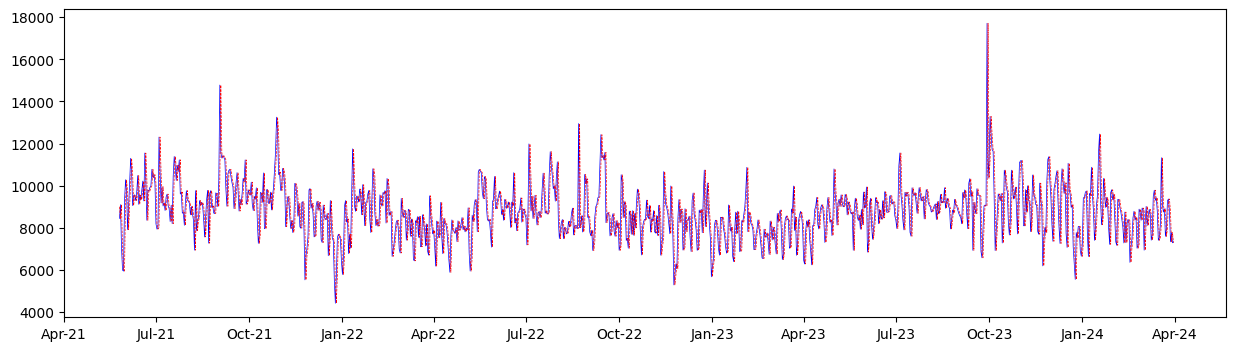

In [59]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(test_df['Count'], 'b-', label='Actual', linewidth=0.5)
ax.plot(test_df['Pred_Baseline'], 'r--', label='Prediction: 1-day shift', linewidth=0.5)
plt.xticks(ticks=[pd.Timestamp('2021-04-01'), pd.Timestamp('2021-07-01'), pd.Timestamp('2021-10-01'), pd.Timestamp('2022-01-01'),
                  pd.Timestamp('2022-04-01'), pd.Timestamp('2022-07-01'), pd.Timestamp('2022-10-01'), pd.Timestamp('2023-01-01'),
                  pd.Timestamp('2023-04-01'), pd.Timestamp('2023-07-01'), pd.Timestamp('2023-10-01'), pd.Timestamp('2024-01-01'),
                  pd.Timestamp('2024-04-01')],
           labels=['Apr-21', 'Jul-21', 'Oct-21', 'Jan-22', 'Apr-22', 'Jul-22', 'Oct-22', 'Jan-23', 'Apr-23', 'Jul-23', 'Oct-23',
                   'Jan-24', 'Apr-24'])
#fig.autofmt_xdate()
plt.show()

# First Simple Model: SARIMAX (1 seasonal adjustment)

In [53]:
result = adfuller(df_311_pivot['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.520885912394666
p-value: 0.11047490316084041


<b>Not stationary</b>  
Because the p-value of the ADF statistics is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [62]:
# Transform the data by taking the one-day difference
df_311_pivot['Count_diff'] = df_311_pivot['Count'].diff().dropna()
result_diff = adfuller(df_311_pivot['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

ADF Statistic (1st diff): -21.567541398065114
p-value (1st diff): 0.0


<b>Stationary</b>  
The data is now stationary, we can proceed with modeling.

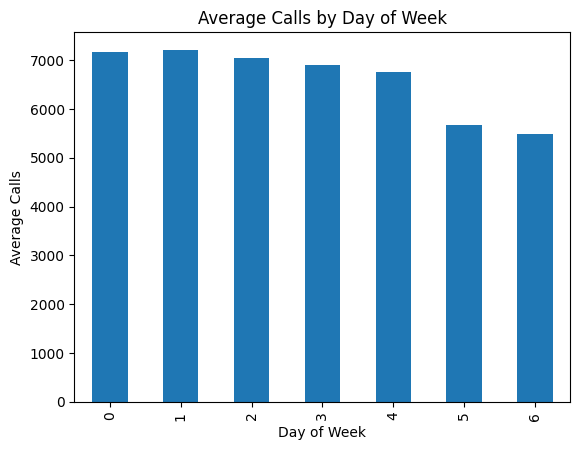

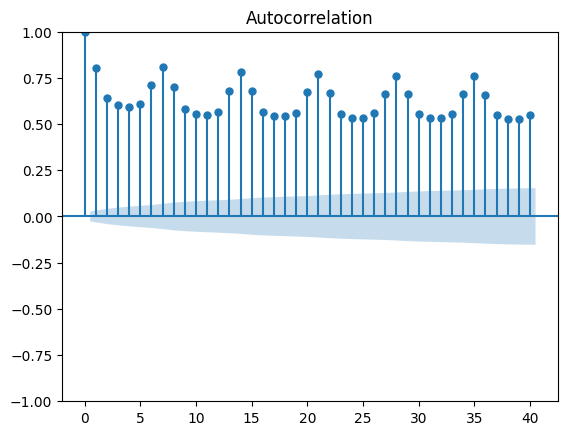

AttributeError: 'Axes' object has no attribute 'plot_acf'

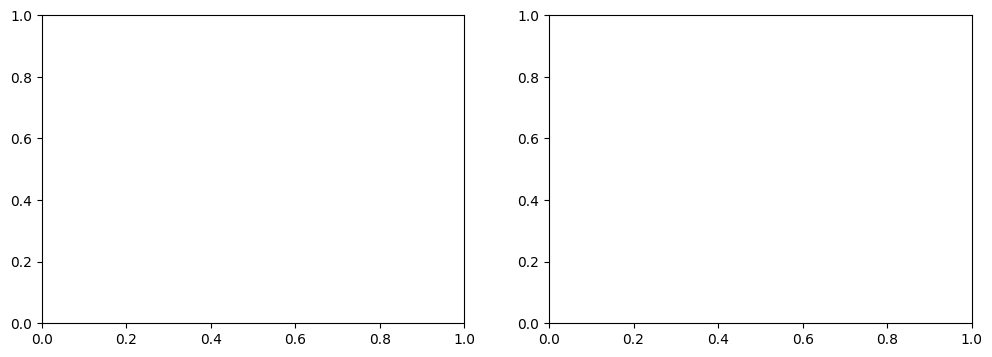

In [68]:
df_311_pivot['day_of_week'] = df_311_pivot.index.dayofweek

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
ax1.plot_acf(df_311_pivot['Count'].dropna(), lags=40)
ax2.bar(x = df_311_pivot['Count'].groupby(df_311_pivot['day_of_week']), height = df_311_pivot['Count'].groupby(df_311_pivot['day_of_week']).mean())

#plt.title('Average Calls by Day of Week')
#plt.xlabel('Day of Week')
#plt.ylabel('Average Calls')
plt.show()

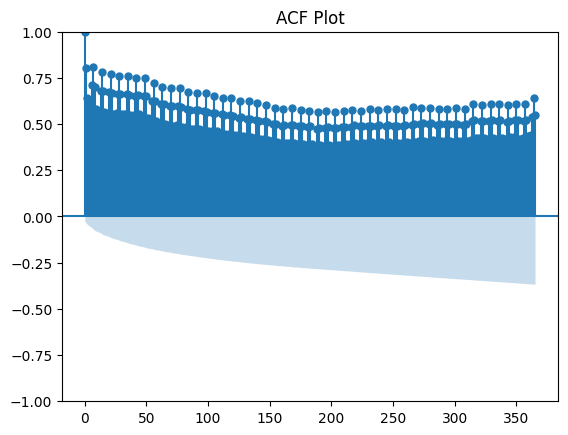

In [70]:
plot_acf(df_311_pivot['Count'].dropna(), lags=365)  # Set lags to cover multiple cycles
plt.title('ACF Plot')
plt.show()

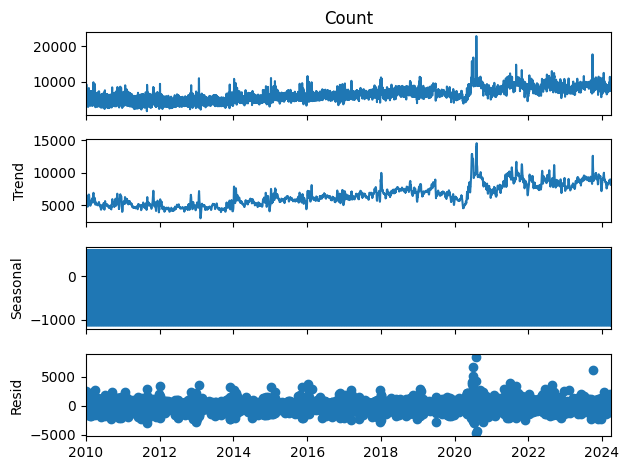

In [88]:
# Perform seasonal decomposition
result = seasonal_decompose(df_311_pivot['Count'], model='additive', period=7)
result.plot()
plt.show()

In [83]:
advanced_decomposition = STL(df_311_pivot['Count'], period=91).fit()

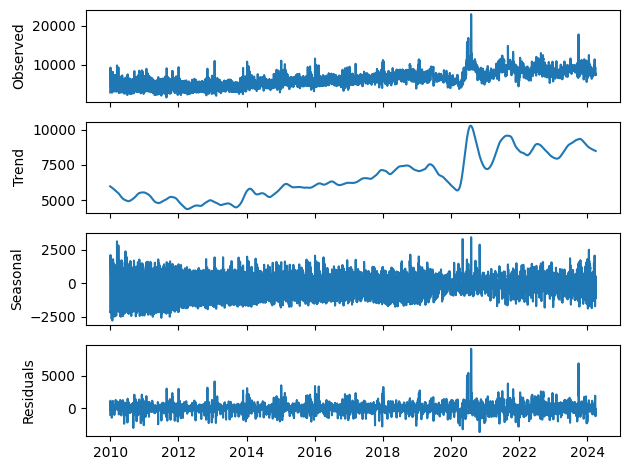

In [84]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.tight_layout()

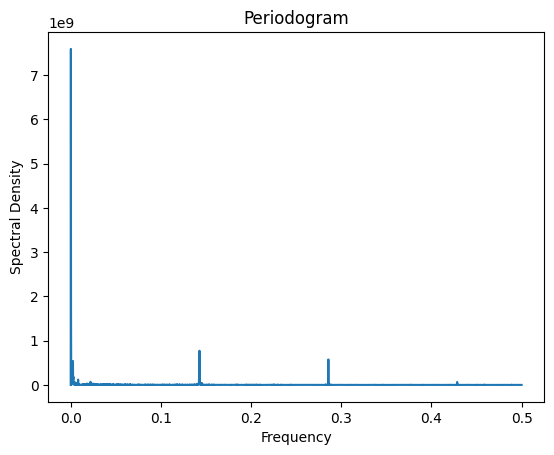

In [85]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df_311_pivot['Count'].dropna())
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Periodogram')
plt.show()